In [25]:
%load_ext line_profiler

In [66]:
import pandas as pd
import os, sys
import numpy as np
import math
from matplotlib import pyplot as plt
from IPython.display import display
from PIL import Image
import PIL
import s3fs 
from sklearn import datasets,linear_model
import cv2
import time

isPlot=False
isPlotDP=False

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])


def axbFit(x_train,y_train):
    regr=linear_model.LinearRegression()
    regr.fit(x_train.reshape(-1, 1),y_train.reshape(-1, 1))  
    r_squared = regr.score(x_train.reshape(-1, 1),y_train.reshape(-1, 1))
    #r_squared = regr.score(x_train, y_train)
    #print('y=ax+b的 a係數:',regr.coef_)
    #print('y=ax+b的 b截距:',regr.intercept_ )
    #print('y=ax+b的 r_squared:',r_squared )
    return regr.coef_, r_squared

def imgWrapA(orgImg,a):
    column=orgImg.shape[1]
    row=orgImg.shape[0]
    #plt.plot( int(column/2),int(row/2),'rx')#fix
    #plt.plot( int(column/2),int(row/4),'bx')#fix
    #plt.plot( int(column/4),int(row/2-column/4*a),'go')#offset
    pts1 = np.float32([[column/2,row/2],[column/2,row/4],[column/4,row/2-column/4*a]])
    pts2 = np.float32([[column/2,row/2],[column/2,row/4],[column/4,row/2]])
    M = cv2.getAffineTransform(pts1,pts2)
    imgWarpAffine = cv2.warpAffine(orgImg,M,(column,row))
    return imgWarpAffine
    

#def tb()
#217606.0 108803.0     68.2      reward, prev=getTrelis(img, row, column, side, orgImg)


def v3GetTrelis(img, row, column, side, orgImg):
    img=img
    #x=np.ones((img.shape[0],img.shape[1],2))*20.00
    #x[:,:,0]=img
    #img=np.min(x,axis=2)
    #thread=np.mean(img)
    #print(thread)
    inc=np.array(range(0-2,row-2))#2 = side
    reward= np.zeros((row,column),dtype=float)
    prev= np.zeros((row,column),dtype=float)
    orgImgM= np.ones((row,column,side*2+1),dtype=float)*(-2)
    columnTrace=column
    #columnTrace=4
    
    rewardM= np.ones((row,side*2+1),dtype=float)*(-1000)
    colInx=0
    orgImgM[1:  ,:,1]=orgImg[ :-1,:]+40.0
    orgImgM[ :  ,:,2]=orgImg[ :  ,:]
    orgImgM[ :-1,:,3]=orgImg[1:  ,:]+40.0
    #for i in range(0, 2*side+1):
    for i in range(1, columnTrace):  # for each stage
        colInx=i-1
        rewardM[1:  ,1]=reward[ :-1,colInx]
        rewardM[ :  ,2]=reward[ :  ,colInx]
        rewardM[ :-1,3]=reward[1:  ,colInx]
        vNewReward=rewardM-abs(orgImgM[:,colInx,:]-orgImg[:,i, None])
        vRelativeMaxIndex=np.argmax(vNewReward,axis=1)
        reward[:,i]=np.max(vNewReward,axis=1)+img[:,i]
        prev[:,i]=inc+vRelativeMaxIndex
        #print(vRelativeMaxIndex)
    if isPlotDP:
        plt.imshow(reward)
        plt.show()
        plt.imshow(prev)
        plt.show()  
        print(reward.shape)
        print(prev.shape)
    return reward, prev

    
def dpDdecode(img, row, column, side, orgImg):
    
    print("row={}, column={}".format(row, column))
    #reward, prev=vvGetTrelis(img, row, column, side, orgImg)
    reward, prev=v3GetTrelis(img, row, column, side, orgImg)
    #reward, prev=vGetTrelis(img, row, column, side, orgImg)
    #reward, prev=getTrelis(img, row, column, side, orgImg)
    columnTrace=column
    

    # traceback
    
    '''    
    rewardMax=np.max(reward[:int(row/2)-1,columnTrace-1])
    #rewardThread=rewardMax/2
    finalMaxIndex=np.argmax(reward[:int(row/2)-1,columnTrace-1])
    tmpIndex=finalMaxIndex
    data_r=np.zeros(columnTrace)
    data_r[columnTrace-1]=row-tmpIndex
        
      
    for i in range(columnTrace-1, 0, -1):  # for each stage
        #print(tmpIndex)
        #print(reward[tmpIndex,i])
        tmpIndex=int(prev[tmpIndex,i])
        #data_r[i-1]=row-tmpIndex
        data_r[i-1]=tmpIndex

  
    finalMaxIndex2=np.argmax(reward[int(row/2)+1:,columnTrace-1]) +int(row/2)+1
    tmpIndex2=finalMaxIndex2
    data_r2=np.zeros(columnTrace)
    data_r2[columnTrace-1]=row-tmpIndex2
        
    for i2 in range(columnTrace-1, 0, -1):  # for each stage
        #print(tmpIndex)
        #print(reward[tmpIndex,i])
        tmpIndex2=int(prev[tmpIndex2,i2])
        #data_r[i-1]=row-tmpIndex
        data_r2[i2-1]=tmpIndex2

        
    plt.plot(-data_r[:-1],'+')
    plt.plot(-data_r2[:-1])
    plt.plot(-data_r2[:-1]*0.5-data_r[:-1]*0.5,'o')
    plt.show()
    a, r_squared=axbFit(np.arange(len(data_r)-1),data_r[:-1])
    '''
    
    
    #data_r_s=np.zeros([columnTrace,row])
    #data_r_s[columnTrace-1,row]=row-tmpIndex
    r_x_squared_min=9999.0
    r_x_squared_min_index=0
    data_r_min=np.zeros(columnTrace)
    r_x_squared_max=-9999.0
    r_x_squared_max_index=0
    data_r_max=np.zeros(columnTrace)
    a_x_max=0
    
    center=int(column/2)
    e=int(4*center/3)
    b=int(2*center/3)
    #e=int(6*center/4)
    #b=int(2*center/4)

    #find up line
    for ii in range(2,row-2):
        w=abs(ii/row-0.5)
        tmpIndex=ii
        data_r_x_up=np.zeros(columnTrace)
        data_r_x_up[columnTrace-1]=tmpIndex
        #if reward[tmpIndex,columnTrace-1] < rewardThread:
        #    continue

        for jj in range(columnTrace-1, 0, -1):  # for each stage
            #print(tmpIndex)
            #print(reward[tmpIndex,i])
            tmpIndex=int(prev[tmpIndex,jj])
            #data_r[i-1]=row-tmpIndex
            data_r_x_up[jj-1]=tmpIndex        
        if data_r_x_up[center]>3:
            centerUp=data_r_x_up[center]
            if isPlot:
                plt.plot(-data_r_x_up)## for debug
            print('b={},e={}'.format(b,e))
            print(data_r_x_up[b:e])
            print(np.arange(e-b))
            a_x_up, r_x_squared_up=axbFit(np.arange(e-b),data_r_x_up[b:e])
            break

    maxReward=-9999
    for ii in range(2,int(row/2)):
        tmpIndex=ii
        data_r_x_up_2=np.zeros(columnTrace)
        data_r_x_up_2[columnTrace-1]=tmpIndex
        #if reward[tmpIndex,columnTrace-1] < rewardThread:
        #    continue
        tmpIndex2=tmpIndex
        for jj in range(columnTrace-1, 0, -1):  # for each stage
            tmpIndex2=int(prev[tmpIndex2,jj])
            data_r_x_up_2[jj-1]=tmpIndex2
            #data_r_x_up_2[jj-1]=prev[tmpIndex2,jj]
        #print('ii={}, reward.shape[0]={} , reward.shape[1]={} row/2={}'.format(ii,reward.shape[0], reward.shape[1],int(row/2)))
            
        #print("reward.shape={}, tmpIndex={}".format(reward.shape,tmpIndex))

        if reward[ii,columnTrace-1]>maxReward and centerUp==data_r_x_up_2[center]:
        ##if reward[tmpIndex,ii]>maxReward and centerUp==data_r_x_up_2[center]:
            #plt.plot(-data_r_x_up_2)## for debug
            maxReward=reward[ii,columnTrace-1]
            ##maxReward=reward[tmpIndex,ii]
            #print('maxReward={},ii={}'.format(maxReward,ii))
            data_r_x_up=data_r_x_up_2
            a_x_up, r_x_squared_up=axbFit(np.arange(e-b),data_r_x_up[b:e])
            #print("reward.shape={}, tmpIndex={}, maxReward={}, r_x_squared_up={}".format(reward.shape,tmpIndex, maxReward, r_x_squared_up))
    if isPlot:
        plt.plot(-data_r_x_up,'r')## for debug
            
    
    #for finding down line
    for ii in range(row-1,0,-1):
        w=abs(ii/row-0.5)
        tmpIndex=ii
        data_r_x_down=np.zeros(columnTrace)
        data_r_x_down[columnTrace-1]=tmpIndex
        #if reward[tmpIndex,columnTrace-1] < rewardThread:
        #    continue

        for jj in range(columnTrace-1, 0, -1):  # for each stage
            #print(tmpIndex)
            #print(reward[tmpIndex,i])
            tmpIndex=int(prev[tmpIndex,jj])
            #data_r[i-1]=row-tmpIndex
            data_r_x_down[jj-1]=tmpIndex        
        if data_r_x_down[center]<row-3:
            if isPlot:
                plt.plot(-data_r_x_down)## for debug
            a_x_down, r_x_squared_down=axbFit(np.arange(e-b),data_r_x_down[b:e])
            break
    print('r_x_squared_down{}, r_x_squared_up={}'.format(r_x_squared_down,r_x_squared_up))
    data_r_x_down_center=data_r_x_down[int(len(data_r_x_down)/2)]
    data_r_x_up_center=data_r_x_up[int(len(data_r_x_up)/2)]
    print('data_r_x_down_center={}, data_r_x_up_center={}'.format(data_r_x_down_center,data_r_x_up_center))

    if r_x_squared_down>0.98:
        a=a_x_down
        data_r_max=data_r_x_down
    elif r_x_squared_up>0.98:
        a=a_x_up
        data_r_max=data_r_x_up
    elif abs(data_r_x_down_center+data_r_x_up_center)>row:
        a=a_x_down
        data_r_max=data_r_x_down
    else:
        a=a_x_up
        data_r_max=data_r_x_up
    if isPlot:
        plt.show()    
        data_r_x_up_len=len(data_r_x_up)
        b=int(0.25*data_r_x_up_len)
        e=int(0.75*data_r_x_up_len)
        plt.hist(np.diff(data_r_x_up[b:e]),10)
        plt.subplots(1,4,figsize=(15,10))
        plt.subplot(1,4,1)
        plt.plot( int(column/2),int(row/2),'rx')#fix
        plt.plot( int(column/2),int(row/4),'bx')#fix
        plt.plot( int(column/4),int(row/2-column/4*a),'go')#offset
        imgWarpAffine=imgWrapA(orgImg,a)
        plt.imshow(orgImg)
        plt.subplot(1,4,2)
        plt.imshow(reward)
        plt.subplot(1,4,3)
        plt.imshow(img)
        plt.plot(data_r_max[:-1],'r')
        plt.subplot(1,4,4)
        plt.imshow(imgWarpAffine)    
        plt.show()
    return data_r_max, a

def rectScale(im):
    print(im.shape)
    myWidth = im.shape[0]
    myHeight = int(myWidth/2)
    print(myWidth)
    print(myHeight)
    nim = cv2.resize(im, (myWidth*2, myHeight*2), interpolation=cv2.INTER_AREA)
    #nim = im.resize((500, 500,3), PIL.Image.ANTIALIAS)
    #nim = im.resize( (myWidth, myHeight), PIL.Image.ANTIALIAS )
    return nim
    

def lp_parser(path,rowOffset, columnOffset, h, w, isdebug):
    isPlot=isdebug
    isPlotDP=isdebug
    isdebug
    
    im = Image.open(path)
    #width=im_org.size[1]
    #height=im_org.size[0]
    #interp : str, optional
    #width=height*2
    
    #im=im_org.resize((width, height), interp='cubic')
    
    #display(im)
    if isPlot:
        display(im.size)
    
    
    pix_color = np.array(im)
    pix_gray = rgb2gray(pix_color)
    left=int(im.size[0]/4)
    print(left)
    
    right=int(3*im.size[0]/4)
    print(right)
  
    top=int(im.size[1]/3)
    print(top)
    
    down=int(2*im.size[1]/3)
    print(down)
    
    left=0
    right=im.size[0]
    top=0+3
    down=im.size[1]-3
    
    cropGrayLR=np.abs(pix_gray[0:-1,left:right]-pix_gray[1:,left:right])
    waveLR, a=dpDdecode(cropGrayLR,cropGrayLR.shape[0],cropGrayLR.shape[1],2, pix_gray[1:,left:right])
    imWrap=imgWrapA(pix_color,a)
    gray = cv2.cvtColor(imWrap,cv2.COLOR_BGR2GRAY)
    y,gray_mask = cv2.threshold(gray,1,1,cv2.THRESH_BINARY)
    if isPlot:
        plt.imshow(imWrap)
        plt.show()    
    imWrap_t = imWrap.copy().transpose(1,0,2) 
    gray_mask_t  = gray_mask.copy().transpose(1,0) 
    #cv2.transpose(imWrap, imWrap_t);
    '''
    plt.imshow(imWrap_t)
    plt.show()
    plt.imshow(gray_mask,'gray')
    plt.show()
    plt.imshow(cropGrayTD)
    plt.show()
    '''
    pix_gray_t=rgb2gray(imWrap_t)
    cropGrayTD=np.abs(pix_gray_t[0:-1,top:down]-pix_gray_t[1:,top:down])
    print(cropGrayTD.shape)
    print(gray_mask_t[0:-1,top:down].shape)
    cropGrayTD_masked=np.multiply(cropGrayTD, gray_mask_t[0:-1,top:down]) 
    cropGrayTD_masked2=np.multiply(cropGrayTD_masked, gray_mask_t[0:-1,top-1:down-1]) 
    cropGrayTD_masked3=np.multiply(cropGrayTD_masked2, gray_mask_t[0:-1,top-2:down-2]) 
    cropGrayTD_masked4=np.multiply(cropGrayTD_masked3, gray_mask_t[0:-1,top+1:down+1]) 
    cropGrayTD_masked5=np.multiply(cropGrayTD_masked4, gray_mask_t[0:-1,top+2:down+2]) 
    #cropGrayTD_masked6=np.multiply(cropGrayTD_masked5, gray_mask_t[5:,top:down]) 
    '''plt.imshow(cropGrayTD_masked-cropGrayTD)        
    plt.show()    
    plt.imshow(cropGrayTD_masked2-cropGrayTD_masked3)   
    plt.show()    
    plt.imshow(cropGrayTD_masked3-cropGrayTD_masked4)    
    plt.show() 
    '''
    waveLR, a_t=dpDdecode(cropGrayTD_masked5,cropGrayTD_masked5.shape[0],cropGrayTD_masked5.shape[1],2, pix_gray_t[1:,top:down])
    imWrap_t_wrap=imgWrapA(imWrap_t,a_t)
    imWrap_t_wrap_t = imWrap_t_wrap.copy().transpose(1,0,2)     
    imWrap_t_wrap_t_scaled=rectScale(imWrap_t_wrap_t)
    
    if isPlot:
        plt.imshow(cropGrayTD)    
        plt.show() 
        plt.imshow(cropGrayTD_masked5)    
        plt.show() 
        plt.imshow(imWrap_t_wrap_t)
        plt.show()
    
    return waveLR,pix_gray[0:-1,left:right],a, imWrap, imWrap_t_wrap_t, cropGrayLR, imWrap_t_wrap_t_scaled


In [64]:

def looAll(path):
    lpRect_s=[]
    pix_gray_s=[]
    imWrap_s=[]
    imWrap_t_wrap_t_s=[]
    imWrap_t_wrap_t_scaled_s=[]
    lpCount=0
    for root,unkown,fNames in os.walk(path):
        for f in fNames:
            lpCount=lpCount+1
            strFpath="{}/{}".format(path,f)
            print(strFpath)
            lpRect, pix_gray, a, imWrap, imWrap_t_wrap_t, cropGrayLR, imWrap_t_wrap_t_scaled=lp_parser(strFpath, 413, 178, 472, 737, False)
            lpRect_s.append(lpRect)
            pix_gray_s.append(pix_gray)
            imWrap_s.append(imWrap)
            imWrap_t_wrap_t_s.append(imWrap_t_wrap_t)
            imWrap_t_wrap_t_scaled_s.append(imWrap_t_wrap_t_scaled)
    return lpRect_s, pix_gray_s, imWrap_s, imWrap_t_wrap_t_s, cropGrayLR, imWrap_t_wrap_t_scaled_s

lpRect_s, pix_gray_s, imWrap_s, imWrap_t_wrap_t_s, cropGrayLR, imWrap_t_wrap_t_scaled_s= looAll('img')
#%lprun -f looAll('img')


img/0_4932XX_1.jpg
45
135
62
124
row=186, column=180
b=60,e=120
[31. 31. 32. 32. 33. 33. 34. 34. 34. 35. 35. 36. 36. 37. 37. 37. 38. 38.
 39. 39. 40. 40. 40. 41. 41. 42. 42. 42. 43. 43. 44. 44. 44. 45. 45. 45.
 46. 46. 47. 47. 48. 48. 48. 49. 49. 50. 50. 50. 51. 51. 51. 52. 52. 52.
 53. 53. 54. 54. 55. 55.]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]
r_x_squared_down0.9985949772689522, r_x_squared_up=0.9977445228769195
data_r_x_down_center=141.0, data_r_x_up_center=44.0
(179, 181)
(179, 181)
row=179, column=181
b=60,e=120
[18. 17. 17. 17. 17. 17. 17. 17. 16. 16. 16. 16. 16. 16. 15. 15. 15. 15.
 15. 15. 15. 14. 14. 14. 14. 14. 14. 13. 13. 13. 13. 13. 13. 13. 12. 12.
 12. 12. 12. 12. 13. 13. 13. 13. 13. 13. 13. 12. 12. 12. 11. 10. 10.  9.
  9.  9.  9.  9.  9.  9.]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 2

r_x_squared_down0.9929818793741363, r_x_squared_up=0.9939256525177961
data_r_x_down_center=95.0, data_r_x_up_center=13.0
(146, 111)
(146, 111)
row=146, column=111
b=36,e=73
[23. 23. 23. 23. 23. 23. 23. 23. 23. 23. 23. 23. 23. 23. 23. 23. 23. 23.
 23. 23. 23. 23. 23. 23. 24. 24. 24. 24. 24. 24. 24. 24. 23. 23. 23. 22.
 21.]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36]
r_x_squared_down1.0, r_x_squared_up=0.01017620806401931
data_r_x_down_center=121.0, data_r_x_up_center=23.0
(117, 147, 3)
117
58
img/6992mj.jpeg
15
45
31
62
row=92, column=61
b=20,e=40
[5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
r_x_squared_down0.9636166687906206, r_x_squared_up=1.0
data_r_x_down_center=75.0, data_r_x_up_center=5.0
(60, 87)
(60, 87)
row=60, column=87
b=28,e=57
[15. 15. 15. 15. 15. 15. 15. 14. 14. 13. 12. 12. 12. 12. 12. 12. 12. 12.
 12. 12. 12. 12. 12. 12. 12.

r_x_squared_down0.9365802833505608, r_x_squared_up=0.913327120223672
data_r_x_down_center=133.0, data_r_x_up_center=10.0
(91, 144, 3)
91
45
img/0_2326YG_1.jpg
16
49
17
35
row=52, column=66
b=22,e=44
[17. 17. 16. 16. 16. 15. 15. 14. 14. 13. 13. 13. 12. 12. 11. 11. 10. 10.
  9.  9.  9.  8.]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
r_x_squared_down0.10662469156810984, r_x_squared_up=0.989066713172263
data_r_x_down_center=42.0, data_r_x_up_center=13.0
(65, 47)
(65, 47)
row=65, column=47
b=15,e=30
[10. 10.  9.  9.  9.  9.  9.  8.  8.  8.  8.  8.  7.  7.  7.]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
r_x_squared_down0.9244565217391306, r_x_squared_up=0.9141281512605041
data_r_x_down_center=61.0, data_r_x_up_center=8.0
(53, 66, 3)
53
26
img/0_3333X5_1.jpg
12
38
15
31
row=46, column=51
b=16,e=33
[ 9.  9. 10. 10. 10. 11. 11. 12. 12. 12. 13. 13. 14. 14. 14. 15. 15.]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
r_x_squared_down0.9820443645083933, r_x_square

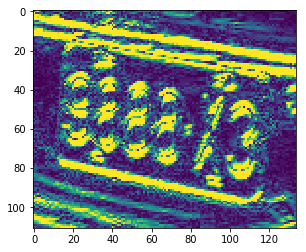

In [133]:
#x=[[np.ones(cropGrayLR.shape)] , [np.ones(cropGrayLR.shape)]]
#x=np.concatenate((np.ones(cropGrayLR.shape),np.ones(cropGrayLR.shape)),axis=2)
cropGrayLR.shape[0]
x=np.ones((cropGrayLR.shape[0],cropGrayLR.shape[1],2))*20.00
x[:,:,0]=cropGrayLR
plt.imshow(np.min(x,axis=2))



In [ ]:
print(len(imWrap_s))
print(int(len(imWrap_s)/6))
#pix_gray_s
plt.subplots(int(len(imWrap_s)/6)+1,6,figsize=(15,10))
    
for ii in range(0,len(imWrap_s)):
    plt.subplot(int(len(imWrap_s)/6)+1,6,ii+1)
    plt.imshow(imWrap_s[ii])
    
plt.show()

28


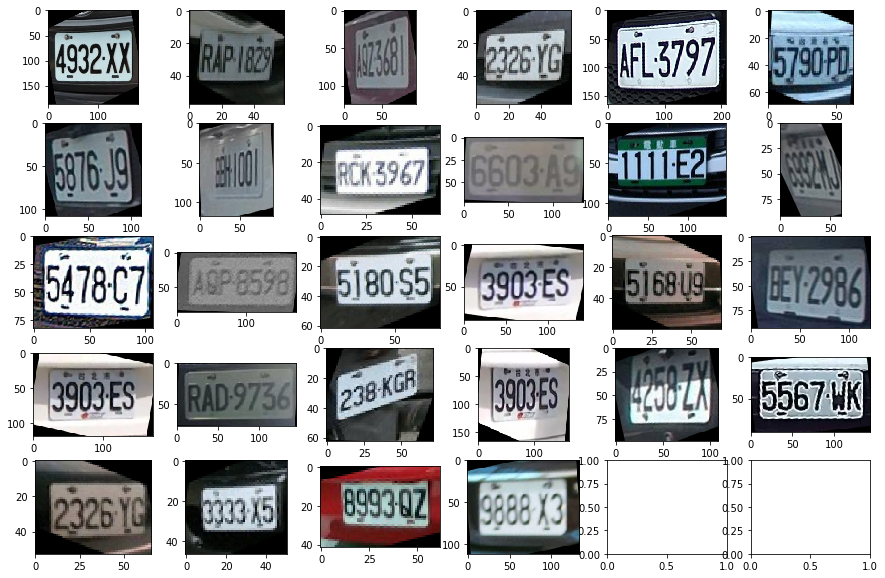

In [20]:
print(len(imWrap_t_wrap_t_s))
#pix_gray_s
plt.subplots(int(len(imWrap_s)/6)+1,6,figsize=(15,10))
    
for ii in range(0,len(imWrap_t_wrap_t_s)):
    plt.subplot(int(len(imWrap_s)/6)+1,6,ii+1)
    plt.imshow(imWrap_t_wrap_t_s[ii])
    
plt.show()

28


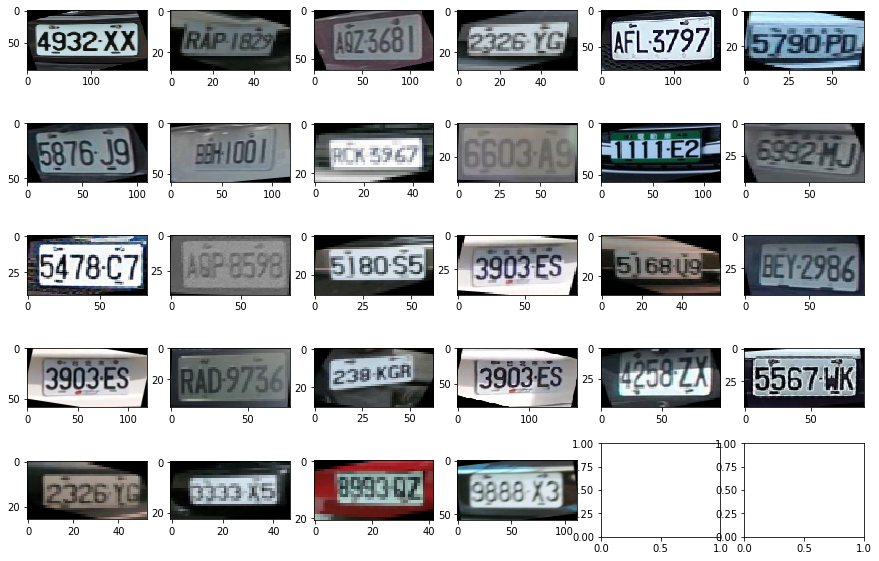

In [67]:
print(len(imWrap_t_wrap_t_scaled_s))
#pix_gray_s
plt.subplots(int(len(imWrap_t_wrap_t_scaled_s)/6)+1,6,figsize=(15,10))
    
for ii in range(0,len(imWrap_t_wrap_t_scaled_s)):
    plt.subplot(int(len(imWrap_t_wrap_t_scaled_s)/6)+1,6,ii+1)
    plt.imshow(imWrap_t_wrap_t_scaled_s[ii])
    
plt.show()

(72, 63)

18
54
21
42
row=62, column=72
b=24,e=48
[12. 12. 12. 11. 11. 10. 10. 10.  9.  9.  8.  8.  8.  8.  8.  8.  8.  8.
  8.  7.  6.  5.  4.  3.]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
r_x_squared_down0.7502666426123037, r_x_squared_up=0.9028262031464225
data_r_x_down_center=40.0, data_r_x_up_center=8.0


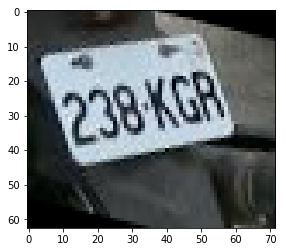

(71, 57)
(71, 57)
row=71, column=57
b=18,e=37
[ 5.  5.  6.  6.  6.  7.  7.  7.  8.  8.  9.  9.  9. 10. 10. 10. 11. 11.
 11.]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
r_x_squared_down0.9709037037037037, r_x_squared_up=0.9796610169491525
data_r_x_down_center=57.0, data_r_x_up_center=9.0


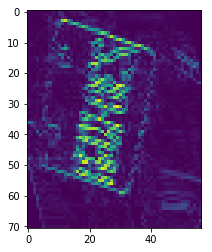

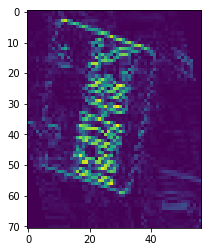

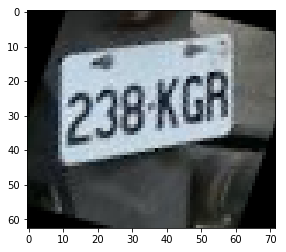

(array([ 4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  5.,  4.,  3.,  3.,
         3.,  4.,  4.,  4.,  5.,  5.,  5.,  6.,  6.,  6.,  7.,  7.,  7.,
         8.,  8.,  9.,  9.,  9., 10., 10., 10., 11., 11., 11., 12., 12.,
        12., 13., 14., 14., 14., 15., 15., 15., 15., 15., 15., 14., 15.,
        15., 16., 16., 16., 16.]),
 array([[ 44.2837,  47.2834,  50.2831, ...,  69.0101,  75.0095,  70.01  ],
        [ 44.2837,  45.2836,  46.2835, ...,  72.0098,  75.0095,  70.01  ],
        [ 42.2839,  41.284 ,  40.2841, ...,  77.0093,  79.0091,  72.0098],
        ...,
        [ 20.0473,  13.048 ,   6.0487, ..., 132.0747, 141.0738, 136.7152],
        [ 11.0482,   7.0486,   3.049 , ..., 125.0754, 110.0769, 112.0767],
        [  5.0488,   4.0489,   5.0488, ..., 135.0744, 121.0758, 106.0773]]),
 array([[-0.2473913]]),
 array([[[39, 41, 40],
         [39, 41, 40],
         [40, 42, 41],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0]],
 
        [[41, 43, 42],
      

In [23]:
#!ls
#!pip install  line_profiler
#!python -m pip install --upgrade pip
testPath='img/0_238KGR_1.jpg'
lp_parser(testPath, 413, 178, 472, 737,True)

In [26]:
testPath='img/0_3333X5_1.jpg'
testPath='img/0_5790PD_1.jpg'
lpRect_s=[]
pix_gray_s=[]
imWrap_s=[]
imWrap_t_wrap_t_s=[]
#lp_parser(testPath, 413, 178, 472, 737)

%lprun -f dpDdecode lp_parser(testPath, 413, 178, 472, 737,False)


15
47
23
46
row=68, column=63
b=20,e=41
[21. 21. 20. 20. 20. 19. 19. 18. 18. 18. 17. 17. 17. 16. 16. 15. 15. 15.
 14. 14. 13.]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
r_x_squared_down0.9865403494993126, r_x_squared_up=0.9851351351351352
data_r_x_down_center=54.0, data_r_x_up_center=17.0
(62, 63)
(62, 63)
row=62, column=63
b=20,e=41
[21. 21. 22. 21. 21. 21. 21. 21. 21. 21. 20. 20. 20. 20. 20. 20. 19. 19.
 19. 19. 19.]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
r_x_squared_down0.6122629169391753, r_x_squared_up=0.8460127591706539
data_r_x_down_center=58.0, data_r_x_up_center=20.0


In [71]:
!python LPRect.py

Figure(1500x1000)


In [31]:
!ls img

0_1111E2_1.jpg	0_3903ES_2.jpg	0_5567WK_1.jpeg  0_AQP8598_1.jpg  6992mj.jpeg
0_2326YG_1.jpg	0_3903ES_3.jpg	0_5790PD_1.jpg	 0_RAD9736_1.jpg  aqz3681.jpeg
0_2326YG_2.jpg	0_4932XX_1.jpg	0_6603A9_1.jpg	 0_RAP1829_2.jpg  bbh1001.jpeg
0_238KGR_1.jpg	0_5168U9_1.jpg	0_8993QZ_2.jpg	 0_RCK3967_3.jpg  bey2986.jpeg
0_3333X5_1.jpg	0_5180S5_1.jpg	0_9888X3_3.jpg	 4258zx.jpeg
0_3903ES_1.jpg	0_5478C7_1.jpg	0_AFL3797_1.jpg  5876j9.jpeg
